In [2]:
from dataclasses import dataclass
from enum import auto
from enum import Enum
from typing import Dict
from typing import Type
from __future__ import annotations
from typing import List
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

class BaseGradientDescent():
    def __init__(self, model, lr: float = 1e-3):
        self.lr  = lr
        self.model = model

    def step(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return self.update_weights(self.model.calc_gradient(x, y))

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        self.model.weights -= self.lr * gradient
        return -self.lr * gradient


class StochasticDescent(BaseGradientDescent):

    def __init__(self, model, lr: float = 1e-3, batch_size: int = 50):
        super().__init__(model, lr)
        self.batch_size = batch_size

    def step(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        pos = np.random.randint(x.shape[0], size=self.batch_size)
        return self.update_weights(self.model.calc_gradient(x[pos], y[pos]))


class MomentumDescent(StochasticDescent):

    def __init__(self, model, lr: float = 1e-3):
        super().__init__(model, lr)
        self.alpha: float = 0.9
        self.prev: np.ndarray = np.zeros(model.dim)

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        self.prev = self.alpha * self.prev + self.lr * gradient
        self.model.weights -= self.prev
        return -self.prev


class Adam(StochasticDescent):

    def __init__(self, model, lr: float = 1e-3):
        super().__init__(model, lr)
        self.eps: float = 1e-8
        self.v: np.ndarray = np.zeros(model.dim)
        self.g: np.ndarray = np.zeros(model.dim)
        self.beta_1: float = 0.9
        self.beta_2: float = 0.995
        self.iteration: int = 0

    def update_weights(self, gradient: np.ndarray) -> np.ndarray:
        self.iteration += 1
        self.v = self.beta_1 * self.v + (1 - self.beta_1) * gradient
        self.g = self.beta_2 * self.g + (1 - self.beta_2) * (gradient)**2
        dif = (self.lr * self.v) / (np.sqrt(self.g) + self.eps)
        self.model.weights -= dif
        return -dif


class LinearRegression:
    def __init__(self, num_features: int, tolerance: float = 1e-4, max_iter: int = 300):
        self.tolerance: float = tolerance
        self.max_iter: int = max_iter
        self.loss_history: List[float] = []
        self.weights = np.random.rand(num_features)
        self.dim = num_features

    def fit(self, x: np.ndarray, y: np.ndarray, descent: BaseGradientDescent) -> LinearRegression:
        self.loss_history.append(self.calc_loss(x, y))
        for i in range(1, self.max_iter):
            weight_diff = descent.step(x, y)
            self.loss_history.append(self.calc_loss(x, y))
            if np.isnan(weight_diff).any():
                raise ValueError("Null gradients")
            if (np.linalg.norm(weight_diff))**2 < self.tolerance:
                break
        return self

    def predict(self, x: np.ndarray) -> np.ndarray:
        return  x @ self.weights

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        return (((y - self.predict(x))/x.shape[0]).T @ (y - self.predict(x)))

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        common_loss_grad = ((x @ (self.weights) - y).T) @ x * 2 / x.shape[0]
        return common_loss_grad


def sigmoid(x):
  return 1 / (1 + np.exp(-x))

class LogisticRegression:

    def __init__(self, num_features, tolerance: float = 1e-4, max_iter: int = 300):
        self.tolerance: float = tolerance
        self.max_iter: int = max_iter
        self.loss_history: List[float] = []
        self.weights = np.random.rand(num_features)
        self.dim = num_features

    def fit(self, x: np.ndarray, y: np.ndarray,  descent: BaseGradientDescent) -> LinearRegression:
        self.loss_history.append(self.calc_loss(x, y))
        for i in range(1, self.max_iter):
            weight_diff = descent.step(x, y)
            self.loss_history.append(self.calc_loss(x, y))
            if np.isnan(weight_diff).any():
              raise ValueError("Null gradients")
            if (np.linalg.norm(weight_diff))**2 < self.tolerance:
              break
        return self

    def predict(self, x: np.ndarray) -> np.ndarray:
        return  sigmoid(x @ self.weights)

    def calc_loss(self, x: np.ndarray, y: np.ndarray) -> float:
        return - np.mean(y * np.log(self.predict(x) + 1e-6) + (1 - y) * np.log(1 + 1e-6 - self.predict(x)))

    def calc_gradient(self, x: np.ndarray, y: np.ndarray) -> np.ndarray:
        return (sigmoid(x @ (self.weights)) - y).T @ x



descent_mapping: Dict[str, Type[BaseGradientDescent]] = {
    'full': BaseGradientDescent,
    'stochastic': StochasticDescent,
    'momentum': MomentumDescent,
    'adam': Adam
}

### Проверка для линейной регрессии на сгенерированных данных

In [3]:
max_iter = 2000
tolerance = 0
num_objects = 100
num_features = 5

x = np.random.rand(num_objects, num_features)
y = x @ [1,2,3,4,5]

descent_config = {
    'descent_name': 'full',
}

lin_gd = LinearRegression(
    num_features=num_features,
    tolerance=tolerance,
    max_iter=max_iter
)


descent = descent_mapping[descent_config['descent_name']](lin_gd)

lin_gd.fit(x, y, descent)

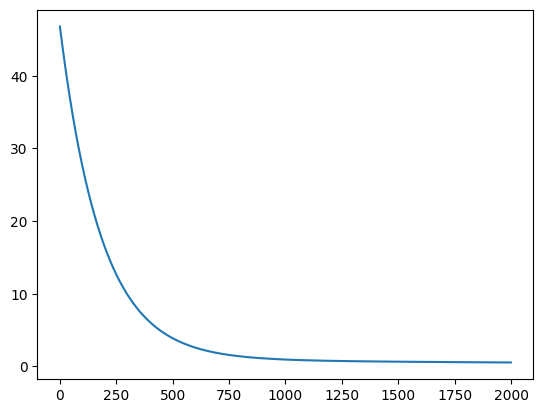

In [4]:
plt.plot(lin_gd.loss_history)

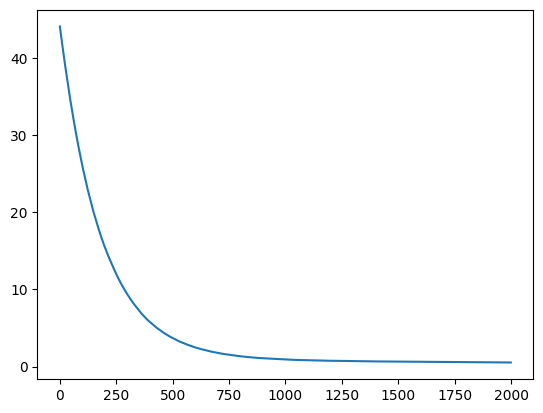

In [5]:
descent_config = {
    'descent_name': 'stochastic',
    'batch_size': 20,
}

lin_sgd = LinearRegression(
    num_features=num_features,
    tolerance=tolerance,
    max_iter=max_iter
)

descent = descent_mapping[descent_config['descent_name']](lin_sgd)

lin_sgd.fit(x, y, descent)

plt.plot(lin_sgd.loss_history)

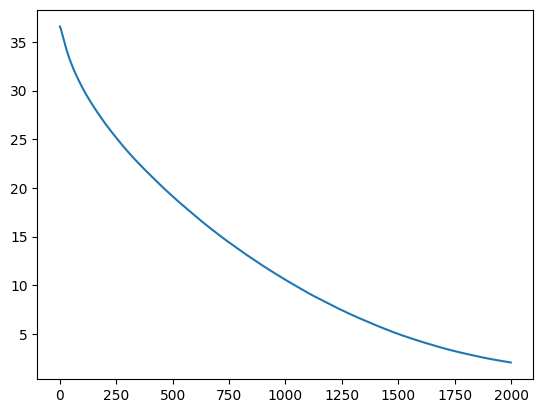

In [6]:

descent_config = {
    'descent_name': 'adam',
    # 'batch_size': 10,
}

lin_adam = LinearRegression(
    num_features=num_features,
    tolerance=tolerance,
    max_iter=max_iter
)

descent = descent_mapping[descent_config['descent_name']](lin_adam)

lin_adam.fit(x, y, descent)


plt.plot(lin_adam.loss_history)

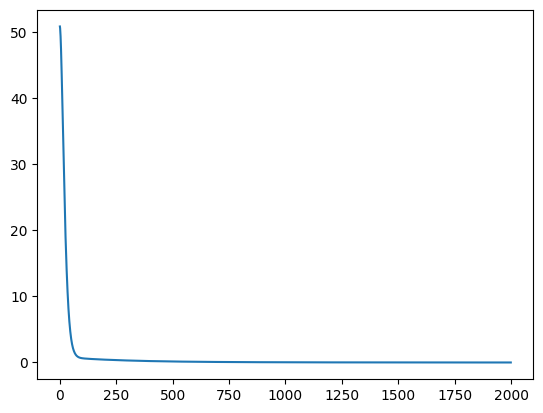

In [7]:
descent_config = {
    'descent_name': 'momentum',
    # 'batch_size': 10,
}

lin_mom = LinearRegression(
    num_features=num_features,
    tolerance=tolerance,
    max_iter=max_iter
)


descent = descent_mapping[descent_config['descent_name']](lin_mom)

lin_mom.fit(x, y, descent)

plt.plot(lin_mom.loss_history)

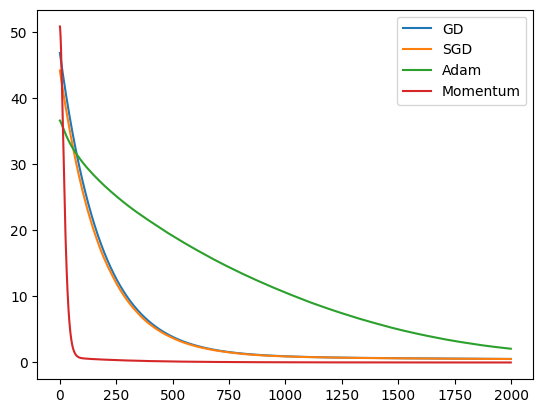

In [8]:
plt.plot(lin_gd.loss_history, label = "GD")
plt.plot(lin_sgd.loss_history, label = "SGD")
plt.plot(lin_adam.loss_history, label = "Adam")
plt.plot(lin_mom.loss_history, label = "Momentum")
plt.legend()

### Проверка для логистической регрессии на сгенерированных данных

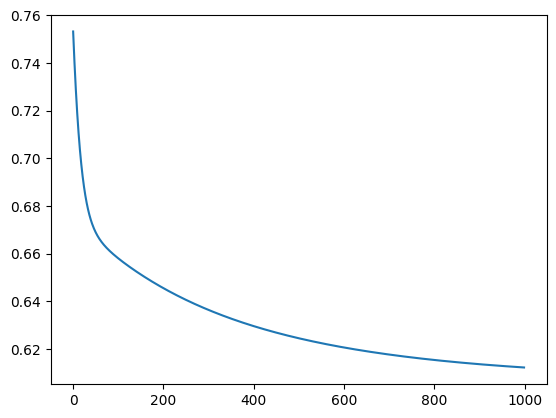

In [9]:
max_iter = 1000
tolerance = 0
num_objects = 100
num_features = 5

x = np.random.rand(num_objects, num_features)
y = x @ [1,2,3,4,5] > np.mean(x @ [1,2,3,4,5])

descent_config = {
    'descent_name': 'full',
    # 'batch_size': 10,
}

log_gd = LogisticRegression(
    num_features=num_features,
    tolerance=tolerance,
    max_iter=max_iter
)

descent = descent_mapping[descent_config['descent_name']](log_gd)

log_gd.fit(x, y, descent)

plt.plot(log_gd.loss_history)

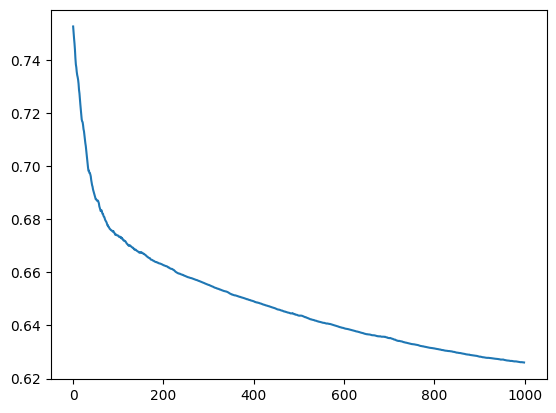

In [10]:
descent_config = {
    'descent_name': 'stochastic',
    'batch_size': 20,
}

log_sgd = LogisticRegression(
    num_features=num_features,
    tolerance=tolerance,
    max_iter=max_iter
)

descent = descent_mapping[descent_config['descent_name']](log_sgd)

log_sgd.fit(x, y, descent)


plt.plot(log_sgd.loss_history)

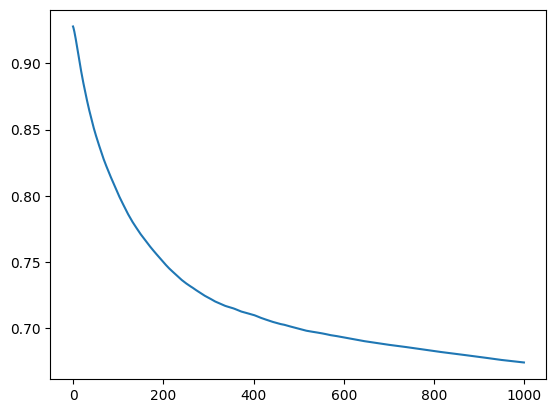

In [11]:
descent_config = {
    'descent_name': 'adam',
    # 'batch_size': 10,
}

log_adam = LogisticRegression(
    num_features=num_features,
    tolerance=tolerance,
    max_iter=max_iter
)

descent = descent_mapping[descent_config['descent_name']](log_adam)

log_adam.fit(x, y, descent)

plt.plot(log_adam.loss_history)

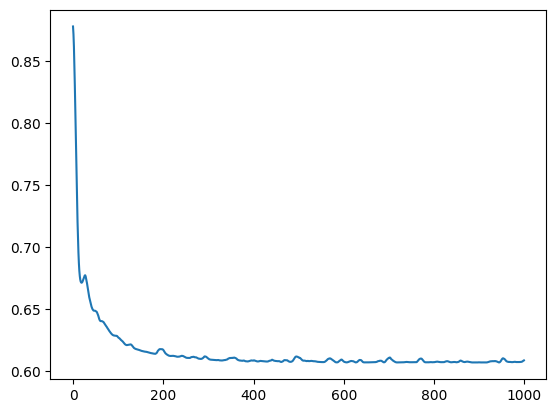

In [12]:
descent_config = {
    'descent_name': 'momentum',
    # 'batch_size': 10,
}

log_momentum = LogisticRegression(
    num_features=num_features,
    tolerance=tolerance,
    max_iter=max_iter
)

descent = descent_mapping[descent_config['descent_name']](log_momentum)

log_momentum.fit(x, y, descent)

plt.plot(log_momentum.loss_history)

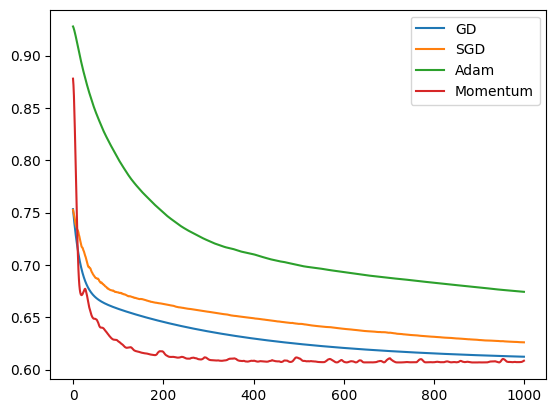

In [13]:
plt.plot(log_gd.loss_history, label = "GD")
plt.plot(log_sgd.loss_history, label = "SGD")
plt.plot(log_adam.loss_history, label = "Adam")
plt.plot(log_momentum.loss_history, label = "Momentum")
plt.legend()

### Проверка для линейной регрессии на реальных данных

In [ ]:
!unzip archive.zip -d archive

Archive:  archive.zip
replace archive/WineQT.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [ ]:
df_lin = pd.read_csv("/content/archive/WineQT.csv")
df_lin.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [ ]:
df_lin.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'Id'],
      dtype='object')

In [ ]:
x = df_lin[['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol']]
y = df_lin.quality

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=10)

In [ ]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# scaler = MinMaxScaler()
scaler = StandardScaler()

x_scaled = scaler.fit_transform(X_train.to_numpy())
x_scaled

array([[-0.57419631, -0.80391506,  0.20655038, ...,  0.62513181,
        -0.71464463, -0.95466481],
       [-0.00957509, -1.41886253,  1.06329885, ..., -0.32504082,
        -0.23563816,  1.80797246],
       [-0.74358267,  0.31417124, -1.35575566, ...,  0.62513181,
        -1.13377529, -0.12587363],
       ...,
       [-0.2918857 , -1.19524527,  0.86171097, ...,  0.11837307,
         0.72237477,  0.51874174],
       [-0.80004479, -0.52439349, -1.35575566, ...,  0.05502823,
        -0.4751414 ,  0.88709337],
       [ 0.38565977,  0.87321439, -1.35575566, ...,  0.24506276,
        -0.35538978, -1.04675272]])

In [ ]:
def add_ones(x):
  return np.concatenate([x, np.ones((x.shape[0], 1))], axis=-1)

In [ ]:
max_iter = 5000
tolerance = 0
num_objects = 100
num_features = X_train.shape[1] + 1
x = add_ones(x_scaled)
y = y_train.values

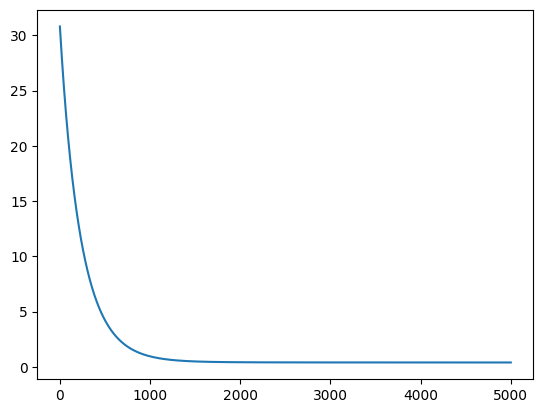

In [ ]:
descent_config = {
    'descent_name': 'full',
}

full_lin_reg = LinearRegression(
    num_features=num_features,
    tolerance=tolerance,
    max_iter=max_iter
)

descent = descent_mapping[descent_config['descent_name']](full_lin_reg)

full_lin_reg.fit(x, y, descent)

plt.plot(full_lin_reg.loss_history)

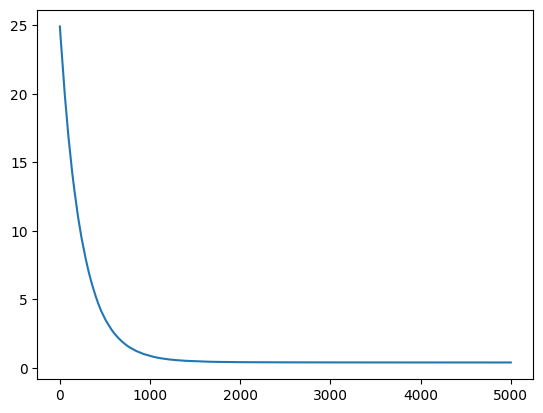

In [ ]:
descent_config = {
    'descent_name': 'stochastic',
    'batch_size': 10
}

st_lin_reg = LinearRegression(
    num_features=num_features,
    tolerance=tolerance,
    max_iter=max_iter
)

descent = descent_mapping[descent_config['descent_name']](st_lin_reg)

st_lin_reg.fit(x, y, descent)
plt.plot(st_lin_reg.loss_history)

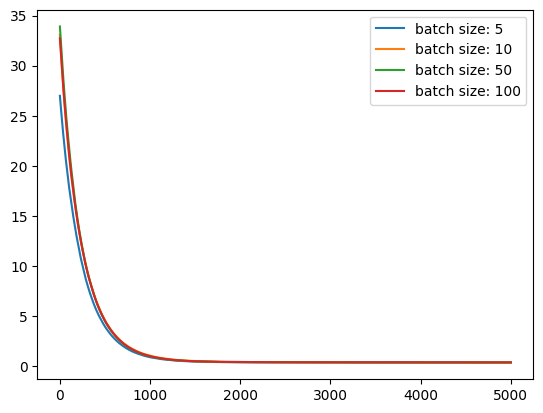

In [ ]:
batches = [5,10,50,100]
st_reg = []
for b_size in batches:

  descent_config = {
      'descent_name': 'stochastic',
      'batch_size': b_size
  }

  st_reg.append(LinearRegression(
      num_features=num_features,
      tolerance=tolerance,
      max_iter=max_iter
  ))

  descent = descent_mapping[descent_config['descent_name']](st_reg[-1])

  st_reg[-1].fit(x, y, descent)
  plt.plot(st_reg[-1].loss_history, label = f'batch size: {b_size}')
plt.legend()

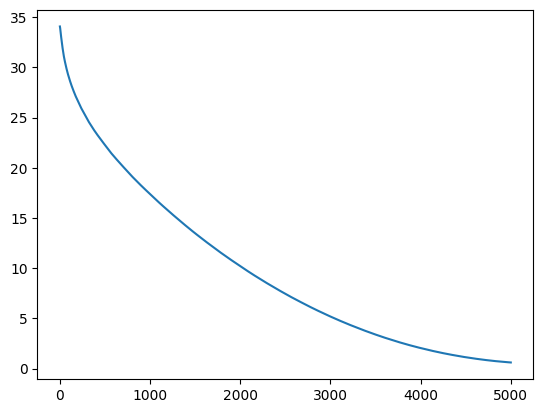

In [ ]:
# max_iter = 2000
descent_config = {
    'descent_name': 'adam'
}

adam_lin_reg = LinearRegression(
    num_features=num_features,
    tolerance=tolerance,
    max_iter=max_iter
)

descent = descent_mapping[descent_config['descent_name']](adam_lin_reg)

adam_lin_reg.fit(x, y, descent)
plt.plot(adam_lin_reg.loss_history)

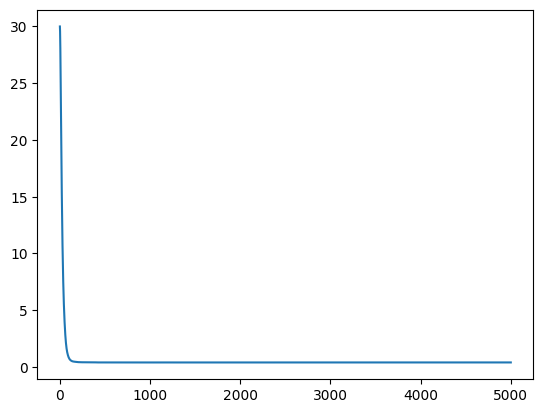

In [ ]:
# max_iter = 1000
descent_config = {
    'descent_name': 'momentum'
}

mom_lin_reg = LinearRegression(
    num_features=num_features,
    tolerance=tolerance,
    max_iter=max_iter
)

descent = descent_mapping[descent_config['descent_name']](mom_lin_reg)

mom_lin_reg.fit(x, y, descent)
plt.plot(mom_lin_reg.loss_history)

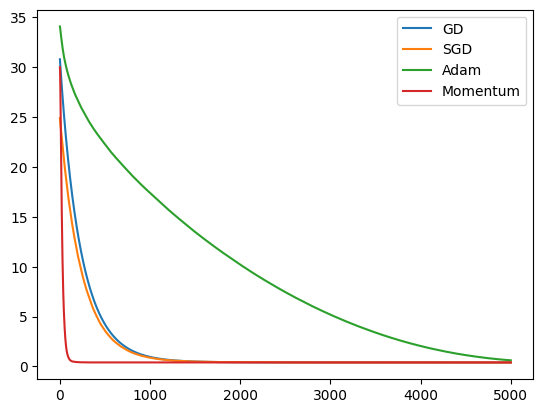

In [ ]:
plt.plot(full_lin_reg.loss_history, label = "GD")
plt.plot(st_lin_reg.loss_history, label = "SGD")
plt.plot(adam_lin_reg.loss_history, label = "Adam")
plt.plot(mom_lin_reg.loss_history, label = "Momentum")
plt.legend()

In [ ]:
from sklearn.metrics import r2_score
x_sc = scaler.transform(X_test.to_numpy())
x_test = add_ones(x_sc)
y_true = y_test

y_pred_gd_lin = full_lin_reg.predict(x_test)
r2 = r2_score(y_true, y_pred_gd_lin)
print("r2 full:", r2)

y_pred_sgd_lin = st_lin_reg.predict(x_test)
r2 = r2_score(y_true, y_pred_sgd_lin)
print("r2 stochastic:", r2)

y_pred_adam_lin = adam_lin_reg.predict(x_test)
r2 = r2_score(y_true, y_pred_adam_lin)
print("r2 adam:", r2)

y_pred_mom_lin = mom_lin_reg.predict(x_test)
r2 = r2_score(y_true, y_pred_mom_lin)
print("r2 momentum:", r2)

r2 full: 0.39127537126391976
r2 stochastic: 0.40622934683777256
r2 adam: 0.07940740988938588
r2 momentum: 0.4042307687136869


In [ ]:
def adjr2(actual: np.ndarray, predicted: np.ndarray, rowcount: np.int, featurecount: np.int):
    """ R2 Score """
    return 1-(1-r2_score(actual,predicted))*(rowcount-1)/(rowcount-featurecount)

In [ ]:
rows = len(y_true)
cols = X_test.shape[1]

y_pred_gd_lin = full_lin_reg.predict(x_test)
r2 = adjr2(y_true, y_pred_gd_lin, rows, cols)
print("adj r2 full:", r2)

y_pred_sgd_lin = st_lin_reg.predict(x_test)
r2 = adjr2(y_true, y_pred_sgd_lin, rows, cols)
print("adj r2 stochastic:", r2)

y_pred_adam_lin = adam_lin_reg.predict(x_test)
r2 = adjr2(y_true, y_pred_adam_lin, rows, cols)
print("adj r2 adam:", r2)

y_pred_mom_lin = mom_lin_reg.predict(x_test)
r2 = adjr2(y_true, y_pred_mom_lin, rows, cols)
print("adj r2 momentum:", r2)

adj r2 full: 0.3633522231567601
adj r2 stochastic: 0.37899216091289967
adj r2 adam: 0.03717839199440365
adj r2 momentum: 0.37690190489321374


In [ ]:
from sklearn.linear_model import LinearRegression as LR
reg = LR().fit(x_scaled, y_train)
y_pr = reg.predict(x_test[:, :-1])
print(r2_score(y_test, y_pr))
adjr2(y_true, y_pr, rows, cols)

0.4004008741551335


0.37289632709802945

In [ ]:
from sklearn.metrics import mean_squared_error as mse
print("mse gd:", mse(y_true, y_pred_gd_lin))
print("mse sgd:", mse(y_true, y_pred_sgd_lin))
print("mse adam:", mse(y_true, y_pred_adam_lin))
print("mse momentum:", mse(y_true, y_pred_mom_lin))
print("mse sklearn regression:", mse(y_true, y_pr))

mse gd: 0.47264639180938045
mse sgd: 0.4610353245639783
mse adam: 0.7147973738892087
mse momentum: 0.4625871276199177
mse sklearn regression: 0.46556086280107706


### Проверка для логистической регрессии на реальных данных

In [ ]:
!unzip "diabetes.zip" -d diabetes

Archive:  diabetes.zip
  inflating: diabetes/diabetes.csv   


In [ ]:
df_log2 = pd.read_csv("/content/diabetes/diabetes.csv")
df_log2.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
df_log2.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [ ]:
x = df_log2[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']]
y = df_log2['Outcome']
x_scaled = scaler.fit_transform(x.to_numpy())

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.2, random_state=42)

In [ ]:
x = add_ones(X_train)
y = y_train.values
max_iter = 2000
tolerance = 0
num_objects = X_train.shape[0]
num_features = X_train.shape[1] + 1

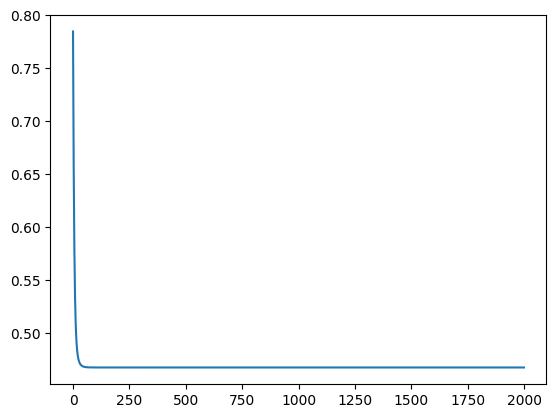

In [ ]:
descent_config = {
    'descent_name': 'full'
}

full_log_reg = LogisticRegression(
    num_features=num_features,
    tolerance=tolerance,
    max_iter=max_iter
)

descent = descent_mapping[descent_config['descent_name']](full_log_reg)

full_log_reg.fit(x, y, descent)

plt.plot(full_log_reg.loss_history)

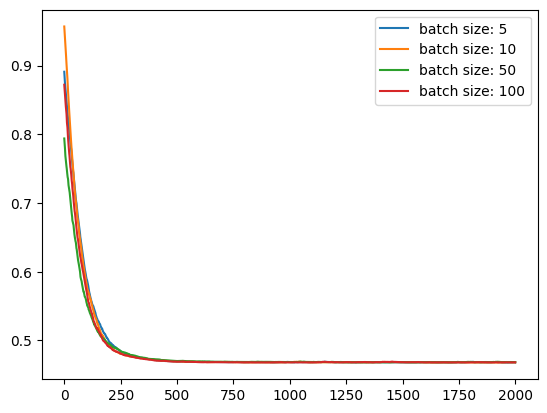

In [ ]:
batches = [5,10,50,100]
st_reg_log = []
for b_size in batches:

  descent_config = {
      'descent_name': 'stochastic',
      'batch_size': b_size
  }

  st_reg_log.append(LogisticRegression(
      num_features=num_features,
      tolerance=tolerance,
      max_iter=max_iter
  ))

  descent = descent_mapping[descent_config['descent_name']](st_reg_log[-1])

  st_reg_log[-1].fit(x, y, descent)
  plt.plot(st_reg_log[-1].loss_history, label = f'batch size: {b_size}')
plt.legend()

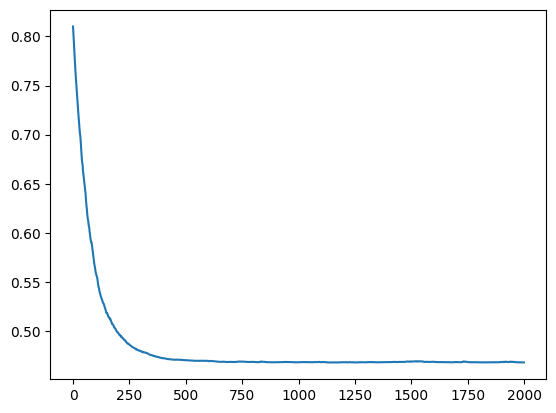

In [ ]:
descent_config = {
    'descent_name': 'stochastic',
    'batch_size': 50
}

st_log_reg = LogisticRegression(
    num_features=num_features,
    tolerance=tolerance,
    max_iter=max_iter
)

descent = descent_mapping[descent_config['descent_name']](st_log_reg)

st_log_reg.fit(x, y, descent)
plt.plot(st_log_reg.loss_history)

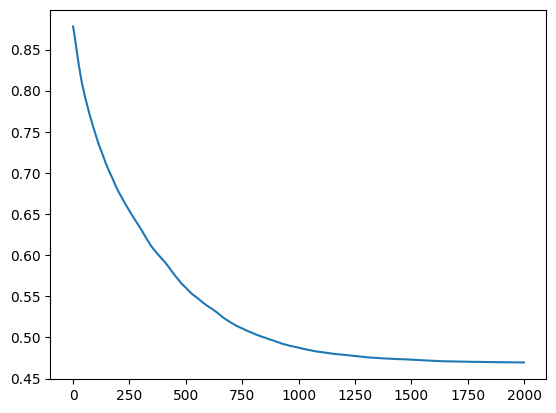

In [ ]:
# max_iter = 10000
descent_config = {
    'descent_name': 'adam'
}

adam_log_reg = LogisticRegression(
    num_features=num_features,
    tolerance=tolerance,
    max_iter=max_iter
)

descent = descent_mapping[descent_config['descent_name']](adam_log_reg)

adam_log_reg.fit(x, y, descent)
plt.plot(adam_log_reg.loss_history)

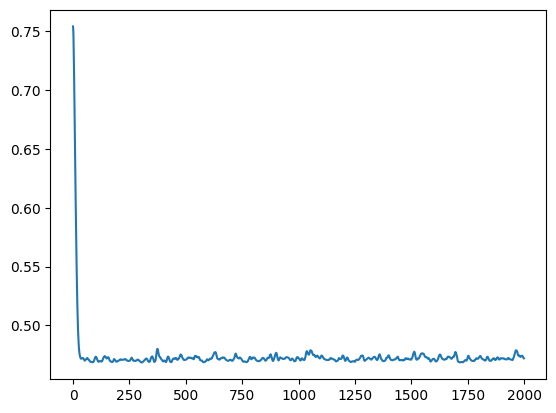

In [ ]:
descent_config = {
    'descent_name': 'momentum'
}

mom_log_reg = LogisticRegression(
    num_features=num_features,
    tolerance=tolerance,
    max_iter=max_iter
)
descent = descent_mapping[descent_config['descent_name']](mom_log_reg)

mom_log_reg.fit(x, y, descent)
plt.plot(mom_log_reg.loss_history)

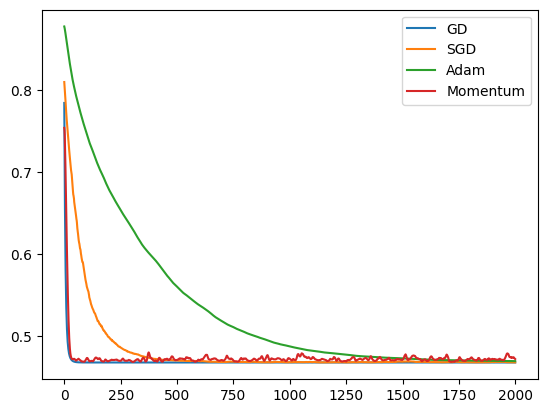

In [ ]:
plt.plot(full_log_reg.loss_history, label = "GD")
plt.plot(st_log_reg.loss_history, label = "SGD")
plt.plot(adam_log_reg.loss_history, label = "Adam")
plt.plot(mom_log_reg.loss_history, label = "Momentum")
plt.legend()

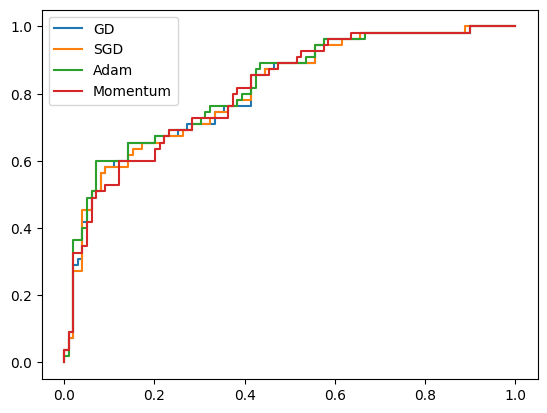

In [ ]:
from sklearn.metrics import roc_curve
x_test = np.concatenate([X_test, np.ones((X_test.shape[0], 1))], axis=-1)

y_pred_gd_log = full_log_reg.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_gd_log)
plt.plot(fpr, tpr, label = "GD")

y_pred_sgd_log = st_log_reg.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_sgd_log)
plt.plot(fpr, tpr, label = "SGD")


y_pred_adam_log = adam_log_reg.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_adam_log)
plt.plot(fpr, tpr, label = "Adam")


y_pred_mom_log = mom_log_reg.predict(x_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_mom_log)
plt.plot(fpr, tpr, label = "Momentum")

plt.legend()

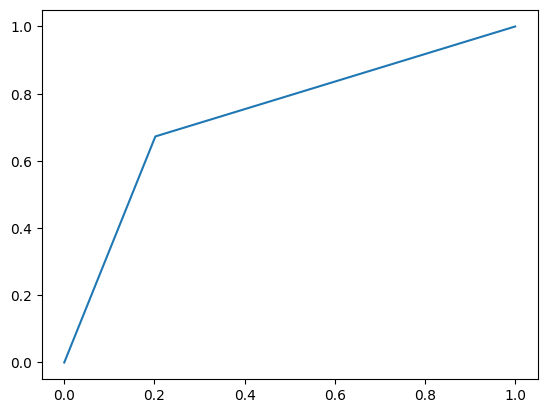

In [ ]:
reg = sklearn.linear_model.LogisticRegression().fit(X_train, y_train)
y_pr = reg.predict(x_test[:, :-1])
fpr, tpr, thresholds = roc_curve(y_test, y_pr)
plt.plot(fpr, tpr)

In [ ]:
from sklearn.metrics import roc_auc_score
print("gd:", roc_auc_score(y_test, y_pred_gd_log))
print("sgd:", roc_auc_score(y_test, y_pred_sgd_log))
print("adam:", roc_auc_score(y_test, y_pred_adam_log))
print("mom:", roc_auc_score(y_test, y_pred_mom_log))
print("sklearn:", roc_auc_score(y_test, y_pr))


gd: 0.8143250688705234
sgd: 0.8119375573921028
adam: 0.820752984389348
mom: 0.810651974288338
sklearn: 0.7353535353535354
